# Experiments in Keras - MNIST

## Approach

For the purposes of this notebook, there are three things I am focussing on:
1. Trying different techniques such as **Batch Normalization** and **Dropout** to understand their effect
2. Attempting **Transfer Learning**
3. Using **Hyperas** for **Hyperparameter Optimization**

I shall be splitting the dataset into two parts (**A**. Digits 0 - 4, **B**. Digits 5 - 9).
I will first train a Deep Neural Net (with more layers and neurons than necessary) on **A**.
Then, using the lower layers of the model, I shall build a new model on **B** (using even fewer images).

Of these 3 tasks, I have completed **1**.

Note: Currently, I have used Adam, ELU and He initialization to build my models. This is just a matter of preference. I plan to experiment with other options when I integrate Hyperas. Hyperas will also enable me to create a much more efficient model without overfitting the data (as is the case now). 

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# %load_ext tensorboard

In [3]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [5]:
X_train.shape

(60000, 28, 28)

In [6]:
X_train = X_train / 255.
X_test = X_test / 255.

Here, I split up the dataset into two parts.

**<i>_first</i>** refers to the dataset of digits 0 - 4.
**<i>_second</i>** refers to the dataset of digits 5 - 9.

Also, note that I did not make a validation train and test set because I use the **validation_split** attibute while training my model.

In [7]:
y_train_bool = y_train < 5
X_train_first = X_train[y_train_bool]
y_train_first = y_train[y_train_bool]

y_test_bool = y_test < 5
X_test_first = X_test[y_test_bool]
y_test_first = y_test[y_test_bool]

y_train_bool = ~y_train_bool
X_train_second = X_train[y_train_bool]
y_train_second = y_train[y_train_bool]

y_test_bool = ~y_test_bool
X_test_second = X_test[y_test_bool]
y_test_second = y_test[y_test_bool]

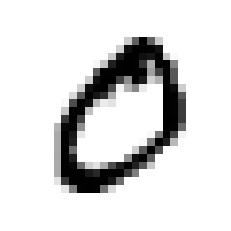

In [8]:
plt.imshow(X_train_first[0], cmap="binary")
plt.axis('off')
plt.show()

Let us look at the first half of the dataset (which we shall be using for training).

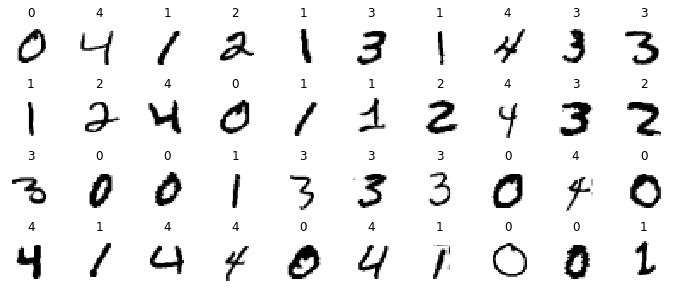

In [9]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_first[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train_first[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let us look at the second half of the dataset (which we shall be using later).

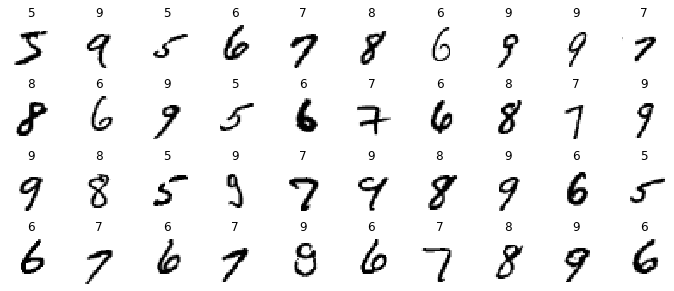

In [10]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_second[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train_second[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let us build our initial model:

In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dense(5, activation="softmax")
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 5

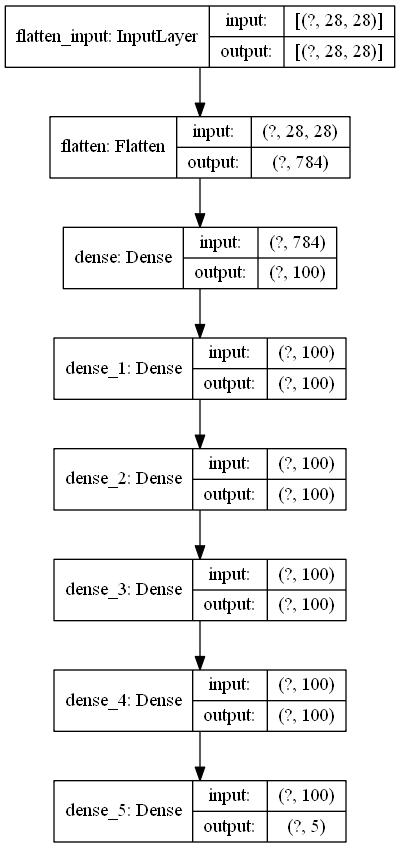

In [13]:
keras.utils.plot_model(model, "mnist.png", show_shapes=True)

In [14]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [15]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("mnist.h5", save_best_only=True)
# run_index = 1
# run_logdir = os.path.join(os.curdir, "mnist_logs", "run_{:03d}".format(run_index))
# tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
callbacks = [early_stopping_cb, model_checkpoint_cb]

In [16]:
history = model.fit(X_train_first, y_train_first,
                    epochs=100,
                    validation_split=0.08,
                    callbacks=callbacks)

Train on 28148 samples, validate on 2448 samples
Epoch 1/100
28148/28148 [==============================] - 17s 599us/sample - loss: 0.1155 - accuracy: 0.9634 - val_loss: 0.0835 - val_accuracy: 0.9775
Epoch 2/100
28148/28148 [==============================] - 9s 313us/sample - loss: 0.0543 - accuracy: 0.9835 - val_loss: 0.0348 - val_accuracy: 0.9906
Epoch 3/100
28148/28148 [==============================] - 7s 260us/sample - loss: 0.0413 - accuracy: 0.9870 - val_loss: 0.0468 - val_accuracy: 0.9882
Epoch 4/100
28148/28148 [==============================] - 9s 312us/sample - loss: 0.0304 - accuracy: 0.9903 - val_loss: 0.0355 - val_accuracy: 0.9906
Epoch 5/100
28148/28148 [==============================] - 8s 267us/sample - loss: 0.0294 - accuracy: 0.9913 - val_loss: 0.0403 - val_accuracy: 0.9886
Epoch 6/100
28148/28148 [==============================] - 9s 324us/sample - loss: 0.0216 - accuracy: 0.9936 - val_loss: 0.0363 - val_accuracy: 0.9898
Epoch 7/100
28148/28148 [===================

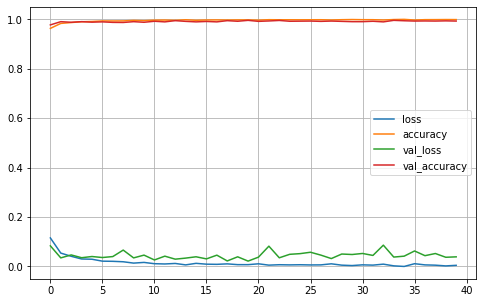

In [17]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [18]:
model.evaluate(X_test_first, y_test_first)

5139/5139 [==============================] - 1s 98us/sample - loss: 0.0315 - accuracy: 0.9922


[0.03151791332442944, 0.9922164]

This is a test to see if callbacks work as intended:

In [19]:
model_test = keras.models.load_model("mnist.h5")
model.evaluate(X_test_first, y_test_first)

5139/5139 [==============================] - 1s 117us/sample - loss: 0.0315 - accuracy: 0.9922


[0.03151791332442944, 0.9922164]

Let us now try adding **Batch Normalization** to our model:

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [21]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(10, activation="softmax")
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               4

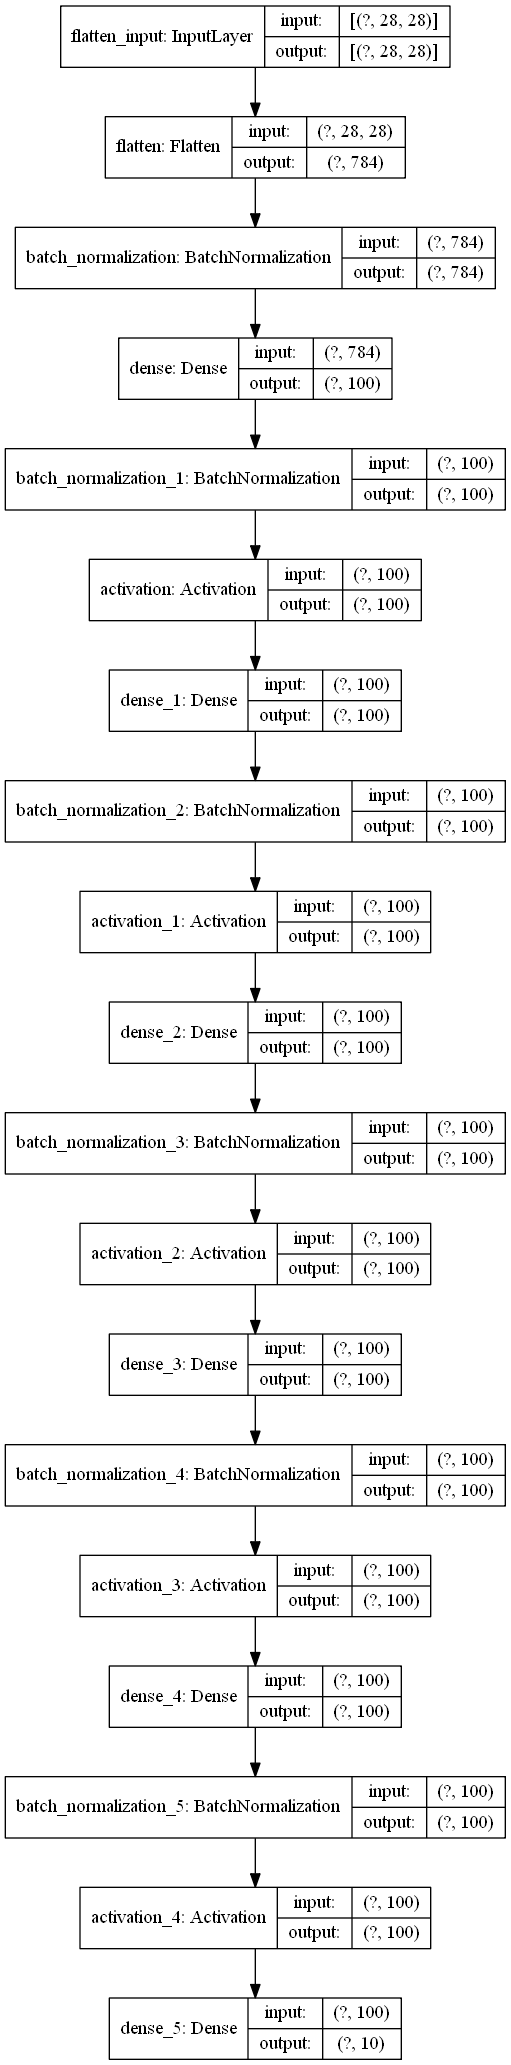

In [23]:
keras.utils.plot_model(model, "mnist_bn.png", show_shapes=True)

In [24]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [25]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("mnist_bn.h5", save_best_only=True)

callbacks = [early_stopping_cb, model_checkpoint_cb]

In [26]:
history = model.fit(X_train_first, y_train_first,
                    epochs=100,
                    validation_split=0.08,
                    callbacks=callbacks)

Train on 28148 samples, validate on 2448 samples
Epoch 1/100
28148/28148 [==============================] - 13s 476us/sample - loss: 0.1530 - accuracy: 0.9563 - val_loss: 0.0564 - val_accuracy: 0.9849
Epoch 2/100
28148/28148 [==============================] - 8s 296us/sample - loss: 0.0767 - accuracy: 0.9766 - val_loss: 0.0473 - val_accuracy: 0.9853
Epoch 3/100
28148/28148 [==============================] - 8s 276us/sample - loss: 0.0547 - accuracy: 0.9823 - val_loss: 0.0372 - val_accuracy: 0.9894
Epoch 4/100
28148/28148 [==============================] - 8s 275us/sample - loss: 0.0440 - accuracy: 0.9862 - val_loss: 0.0366 - val_accuracy: 0.9894
Epoch 5/100
28148/28148 [==============================] - 8s 268us/sample - loss: 0.0390 - accuracy: 0.9870 - val_loss: 0.0376 - val_accuracy: 0.9886
Epoch 6/100
28148/28148 [==============================] - 8s 281us/sample - loss: 0.0323 - accuracy: 0.9888 - val_loss: 0.0345 - val_accuracy: 0.9914
Epoch 7/100
28148/28148 [===================

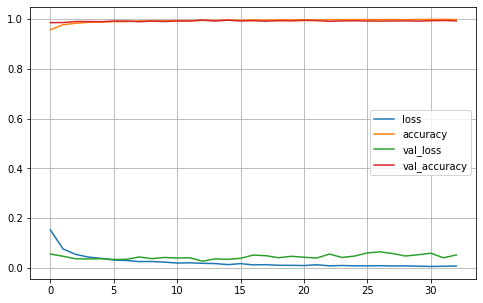

In [27]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [28]:
model.evaluate(X_test_first, y_test_first)

5139/5139 [==============================] - 1s 116us/sample - loss: 0.0467 - accuracy: 0.9899


[0.04670092395923076, 0.9898813]

Let us now add **Dropout**:

In [29]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [30]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1

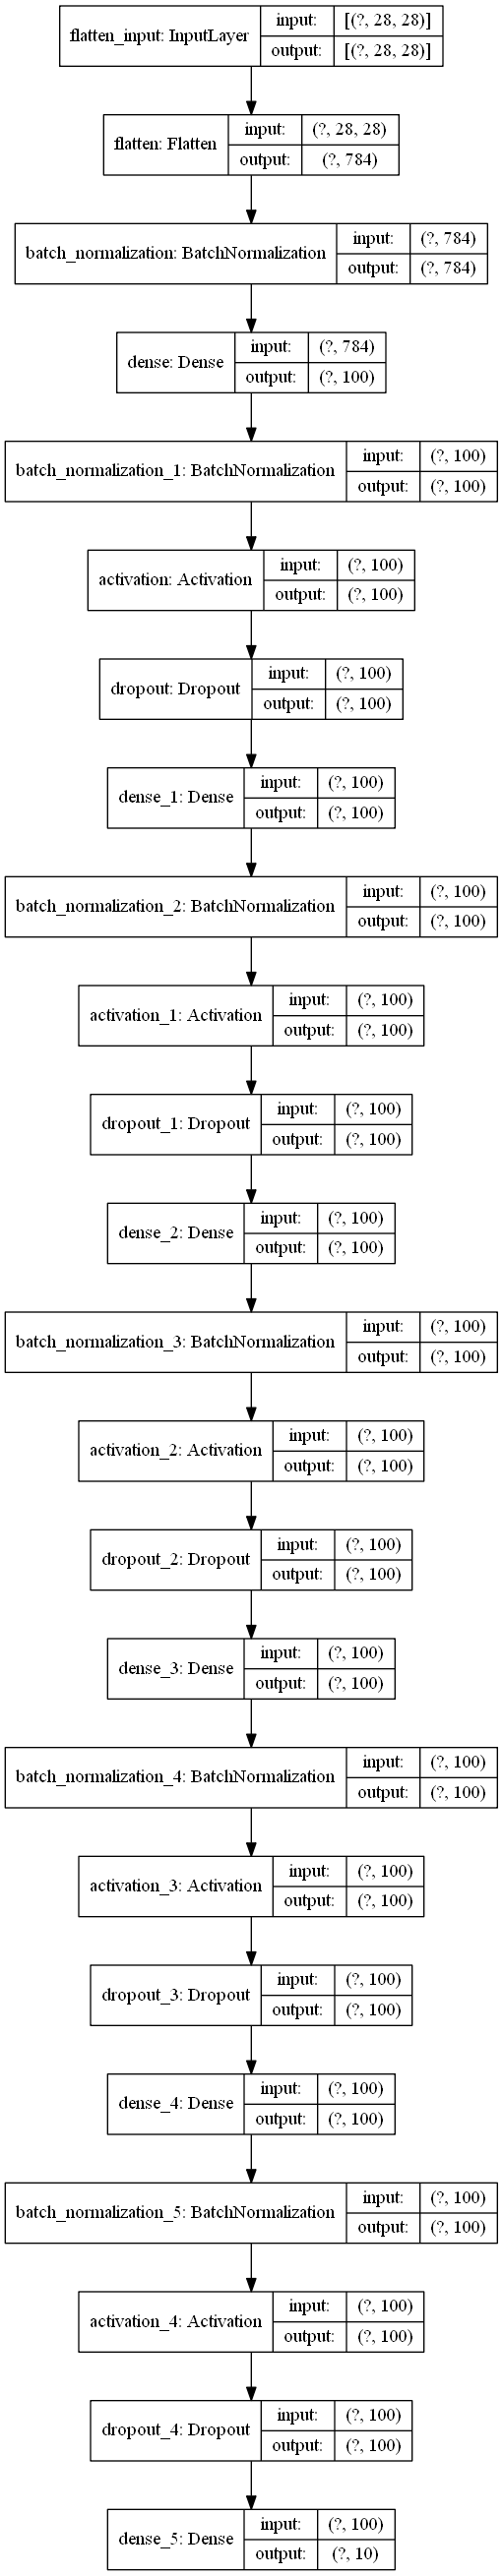

In [32]:
keras.utils.plot_model(model, "mnist_bn_dr.png", show_shapes=True)

In [33]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [34]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("mnist_bn_dr.h5", save_best_only=True)

callbacks = [early_stopping_cb, model_checkpoint_cb]

In [35]:
history = model.fit(X_train_first, y_train_first,
                    epochs=100,
                    validation_split=0.08,
                    callbacks=callbacks)

Train on 28148 samples, validate on 2448 samples
Epoch 1/100
28148/28148 [==============================] - 17s 608us/sample - loss: 0.2439 - accuracy: 0.9298 - val_loss: 0.0590 - val_accuracy: 0.9841
Epoch 2/100
28148/28148 [==============================] - 9s 334us/sample - loss: 0.1385 - accuracy: 0.9583 - val_loss: 0.0506 - val_accuracy: 0.9869
Epoch 3/100
28148/28148 [==============================] - 9s 323us/sample - loss: 0.1109 - accuracy: 0.9654 - val_loss: 0.0478 - val_accuracy: 0.9845
Epoch 4/100
28148/28148 [==============================] - 9s 330us/sample - loss: 0.0937 - accuracy: 0.9722 - val_loss: 0.0400 - val_accuracy: 0.9894
Epoch 5/100
28148/28148 [==============================] - 9s 312us/sample - loss: 0.0803 - accuracy: 0.9740 - val_loss: 0.0407 - val_accuracy: 0.9890
Epoch 6/100
28148/28148 [==============================] - 9s 325us/sample - loss: 0.0721 - accuracy: 0.9762 - val_loss: 0.0372 - val_accuracy: 0.9890
Epoch 7/100
28148/28148 [===================

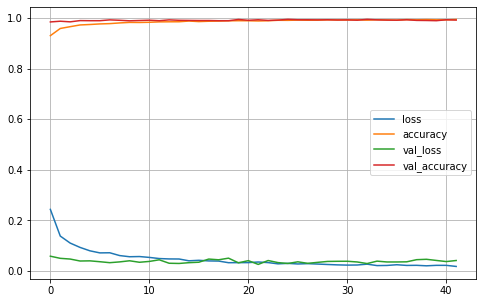

In [36]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [37]:
model.evaluate(X_test_first, y_test_first)

5139/5139 [==============================] - 1s 150us/sample - loss: 0.0345 - accuracy: 0.9889


[0.03449177628314265, 0.98890835]